In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re

In [2]:
df = pd.read_csv("dataset/train.csv")
df['text'] = df['text'].astype("string")

In [3]:
def borrar_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def limpiar_simbolos(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

def borrar_mentions(text):
    mention = re.compile(r'@\S+')
    return mention.sub(r'',text)

def borrar_hashtags(text):
    hashtag = re.compile(r'#\S+')
    return hashtag.sub(r'',text)

def borr_link_mentions(text):
    return borrar_url(borrar_hashtags(text))

def borrar_todo(text):
    return borrar_url(borrar_hashtags(borrar_mentions(text)))

def palabras(text):
    return len(text.split())


In [4]:
import warnings
warnings.filterwarnings('ignore')

df['?'] = df.apply(lambda x: borrar_todo(x.text).count('?'),axis=1)
df['!'] = df.apply(lambda x: borrar_todo(x.text).count('!'),axis=1)
df['@'] = df.apply(lambda x: x.text.count('@'),axis=1)
df['#'] = df.apply(lambda x: x.text.count('#'),axis=1)
df['http'] = df.apply(lambda x: 'http' in x.text,axis=1)
df['numeros'] = df.apply(lambda x: sum(c.isdigit() for c in borrar_todo(x.text)),axis=1)
df['palabras_sin_url'] = df.apply(lambda x: palabras(borrar_url(x.text)),axis=1)
df['tweet_length']=df['text'].str.len()
df

,id,keyword,location,text,target,?,!,@,#,http,numeros,palabras_sin_url,tweet_length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0,0,0,1,False,0,13,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0,0,0,0,False,0,7,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0,0,0,0,False,0,22,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0,0,0,1,False,5,8,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0,0,0,2,False,0,16,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,0,0,0,0,True,0,10,83
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,0,0,2,0,False,0,20,125
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,1,0,0,0,True,8,7,65
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,0,0,0,0,False,0,19,137


'152 a 156 eliminado por no ser relevante'

Text(0.5, 1.0, 'Porcentajes de veracidad por largo de tweet')

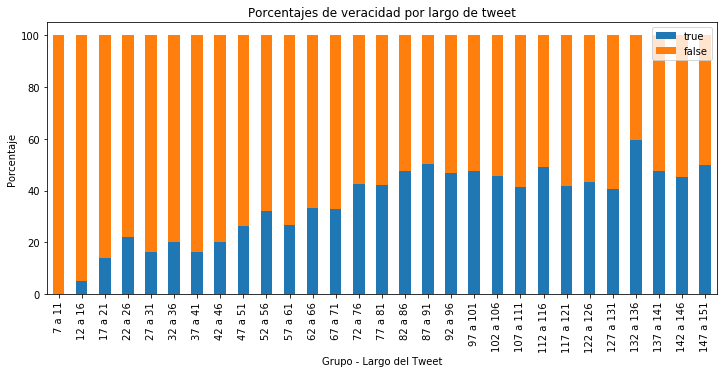

In [5]:
##Analisis porcentaje de Tweets verdaderos por largo
datos=df.groupby(['tweet_length','target']).size().to_frame().unstack().fillna(0).reset_index()
porcentajes = pd.DataFrame()
listaTrue=[]
listaFalse=[]
listaGrupo=[]
cont=-1
for i in range(7,153,5):
    cont=cont+1
    grupo = str(i)+" a "+str(i+4)
    listaGrupo.append(grupo)
    listaFalse.append(datos.loc[datos['tweet_length']>(i-1)].loc[datos['tweet_length']<(i+5)][0][0].sum())
    listaTrue.append(datos.loc[datos['tweet_length']>(i-1)].loc[datos['tweet_length']<(i+5)][0][1].sum())
    if ((listaTrue[cont]+listaFalse[cont])<=10):#Si hay menos de 10 los descarto, pues no aporta nada concreto
        listaTrue.pop(cont)
        listaFalse.pop(cont)
        listaGrupo.pop(cont)
        display(grupo+' eliminado por no ser relevante')
        
        
    
porcentajes['truetemp']=listaTrue
porcentajes['falsetemp']=listaFalse
porcentajes['grupo']=listaGrupo
porcentajes['true']=porcentajes['truetemp']*100/(porcentajes['truetemp']+porcentajes['falsetemp'])
porcentajes['false']=porcentajes['falsetemp']*100/(porcentajes['truetemp']+porcentajes['falsetemp'])
porcentajes=porcentajes.drop(['truetemp','falsetemp'],axis=1)
porcentajes=porcentajes.set_index('grupo')
ax=porcentajes.plot(kind='bar',stacked=True,figsize=(12,5))
ax.set_ylabel('Porcentaje')
ax.set_xlabel('Grupo - Largo del Tweet')
ax.set_title('Porcentajes de veracidad por largo de tweet')

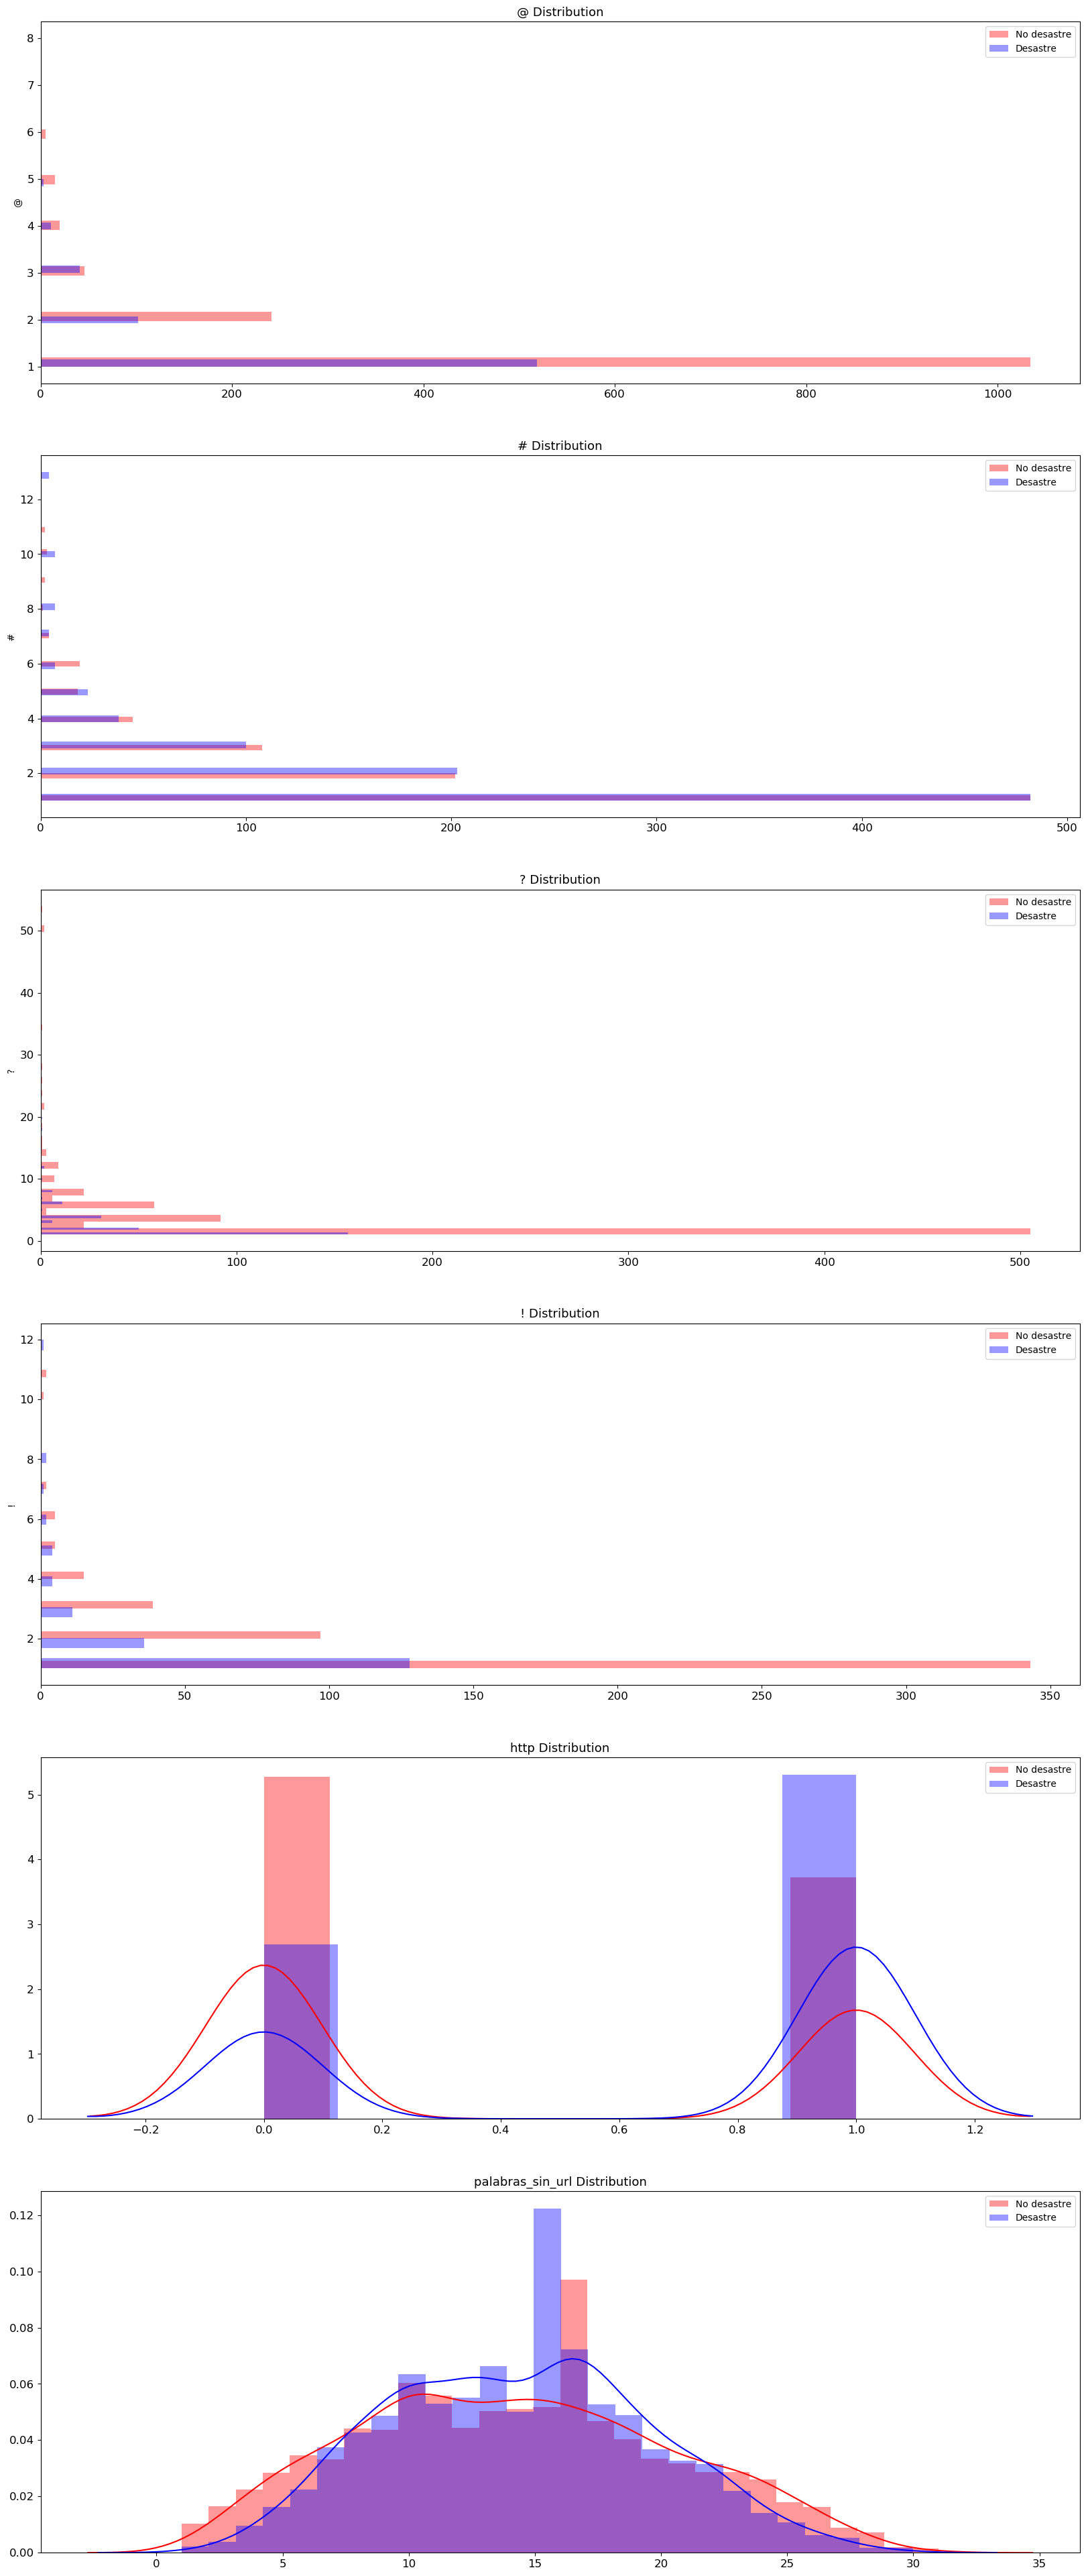

In [6]:
columnas = ['@','#','?','!','http','palabras_sin_url']

verdaderos = (df['target'] == 1)


fig, axes = plt.subplots(ncols=1, nrows=len(columnas), figsize=(20, 50), dpi=100)

for i, columna in enumerate(columnas):
    if columna in '@#?!':
        #Me interesan solo los mayores a 0
        sns.distplot(df.loc[~verdaderos].loc[df[columna]>0][columna], label='No desastre', ax=axes[i], color='red', kde=0, vertical=True)
        sns.distplot(df.loc[verdaderos].loc[df[columna]>0][columna], label='Desastre', ax=axes[i], color='blue',kde=0, vertical=True)
    else:
        sns.distplot(df.loc[~verdaderos][columna], label='No desastre', ax=axes[i], color='red', kde=True)
        sns.distplot(df.loc[verdaderos][columna], label='Desastre', ax=axes[i], color='blue',kde=True)
        
    
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].legend()
    
    axes[i].set_title(f'Distribucion de {columna}', fontsize=13)

plt.show()

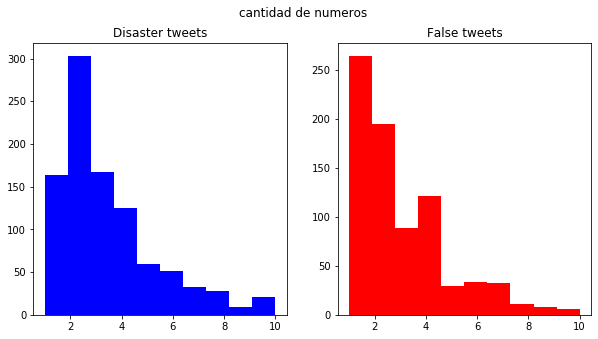

In [7]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
dfreal_graph2=df.loc[df['numeros'] > 0].loc[df['target']==1].loc[df['numeros'] < 11]['numeros']
ax1.hist(dfreal_graph2,color='blue',bins=10)
ax1.set_title('Disaster tweets')
dffalso_graph2=df[df['target']==0].loc[df['numeros'] < 11].loc[df['numeros'] > 0]['numeros']
ax2.hist(dffalso_graph2,color='red',bins=10)
ax2.set_title('False tweets')
fig.suptitle('cantidad de numeros')
plt.show()